# Описание:
Собрать и подготовить свой собственный датасет, можно в соответствии с темой будущего проекта.
Аугментировать данные техниками из занятия.

## Данные:
Свой датасет

## Задачи:
1) Взять предобученную модель. 
    * Cтандартную предобученную модель из библиотек PyTorch `torchvision.models`
    * Примеры: ResNet18, VGG16, EfficientNet.
2) Применить несколько стратегий аугментации данных 
    * Определение стратегий аугментации
    * Пример Torchvision: `transforms.RandomHorizontalFlip`, `transforms.ColorJitter`.
    * Пример Albumentations: `HorizontalFlip`, `RandomBrightnessContrast`, `Cutout`, `ShiftScaleRotate`.
    * Пример сложных: <i>MixUp</i>, <i>CutMix</i>, <i>Mosaic</i>, <i>Weather</i>, <i>Style Transfer</i>.
3) Собрать результаты успешности стратегий в сводную табличку.
    * Базовая аугментация (поворот + отражение).
    * Цветовая аугментация (яркость, контраст).
    * Геометрическая аугментация (поворот, искажение).
    * Сложная аугментация (Cutout + MixUp) - сложно(( ).

Большим плюсом будет применение Pytorch Lightning для упорядочивания вашего проекта, но это не обязательное требование.


## Критерий оценки:
1. Есть сводная табличка в конце со сравнением стратегий.
2. У каждой стратегии есть краткое понятное описание, что именно сделано.
3. Есть визуализация собранного датасета.



In [10]:
import os
import json
import cv2
import torch
import pandas as pd
import numpy as np
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torchvision
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from albumentations.core.transforms_interface import DualTransform

In [38]:
# Установка сидов для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Конфигурация
CLASSES = ["background", "defect"]
TRAIN_IMAGES = "DataForModel/images/Train"  # Путь к тренировочным изображениям
TRAIN_ANN = "DataForModel/annotations/instances_Train.json"  # Путь к тренировочным аннотациям
VAL_IMAGES = "DataForModel/images/Validation"  # Путь к валидационным изображениям
VAL_ANN = "DataForModel/annotations/instances_Validation.json"  # Путь к валидационным аннотациям

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
# Определение стратегий аугментации
base = A.Compose([
                A.Resize(224,224, p=1),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                A.ToTensorV2()
                ],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

color = A.Compose([
                A.Resize(224,224, p=1),
                A.RandomBrightnessContrast(p=0.5),
                A.CLAHE(p=0.3),
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                A.ToTensorV2()
                ],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

geo = A.Compose([
                A.Resize(224,224, p=1),
                A.Perspective(scale=(0.05, 0.1), p=0.3),
                A.ShiftScaleRotate(p=0.3),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                A.ToTensorV2()
                ],bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


no_aug = A.Compose([
                A.Resize(224,224, p=1),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                A.ToTensorV2()
                ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [40]:
# Класс с данными
class FabricDefectDataset(Dataset):
    def __init__(self, root, ann_file, transforms=None):
        self.root = root
        self.transforms = transforms
        
        with open(ann_file) as f:
            data = json.load(f)
        
        self.images = {img['id']: img for img in data['images']}
        self.anns = {}
        for ann in data['annotations']:
            img_id = ann['image_id']
            if img_id not in self.anns:
                self.anns[img_id] = []
            self.anns[img_id].append(ann)
        
        self.ids = list(self.images.keys())
        
    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.images[img_id]
        img_path = os.path.join(self.root, img_info['file_name'])
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        boxes = []
        for ann in self.anns.get(img_id, []):
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
        
        labels = [1] * len(boxes)

        if self.transforms:
            transformed = self.transforms(
                image=img,
                bboxes=boxes,
                labels=labels
            )
            img = transformed['image']
            boxes = transformed['bboxes']
            labels = transformed['labels']

        boxes = torch.as_tensor(boxes, dtype=torch.float32) if len(boxes) > 0 else torch.zeros((0, 4))
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 else torch.zeros(0),
            'iscrowd': torch.zeros(len(boxes), dtype=torch.int64)
        }
        return img, target

    def __len__(self):
        return len(self.ids)
    
# 2. Обновленная функция collate_fn с фильтрацией
def collate_fn(batch):
    images = []
    targets = []
    
    for img, target in batch:
        # Фильтрация битых данных
        if img.shape[0] != 3 or target['boxes'].shape[0] < 0:
            continue
            
        images.append(img)
        targets.append(target)
    
    if len(images) == 0:
        # Возвращаем пустой батч
        print("Пустой батч")
        return [torch.zeros((3, 256, 256))], [{'boxes': torch.zeros((0, 4)), 'labels': torch.zeros(0)}]
    
    return images, targets

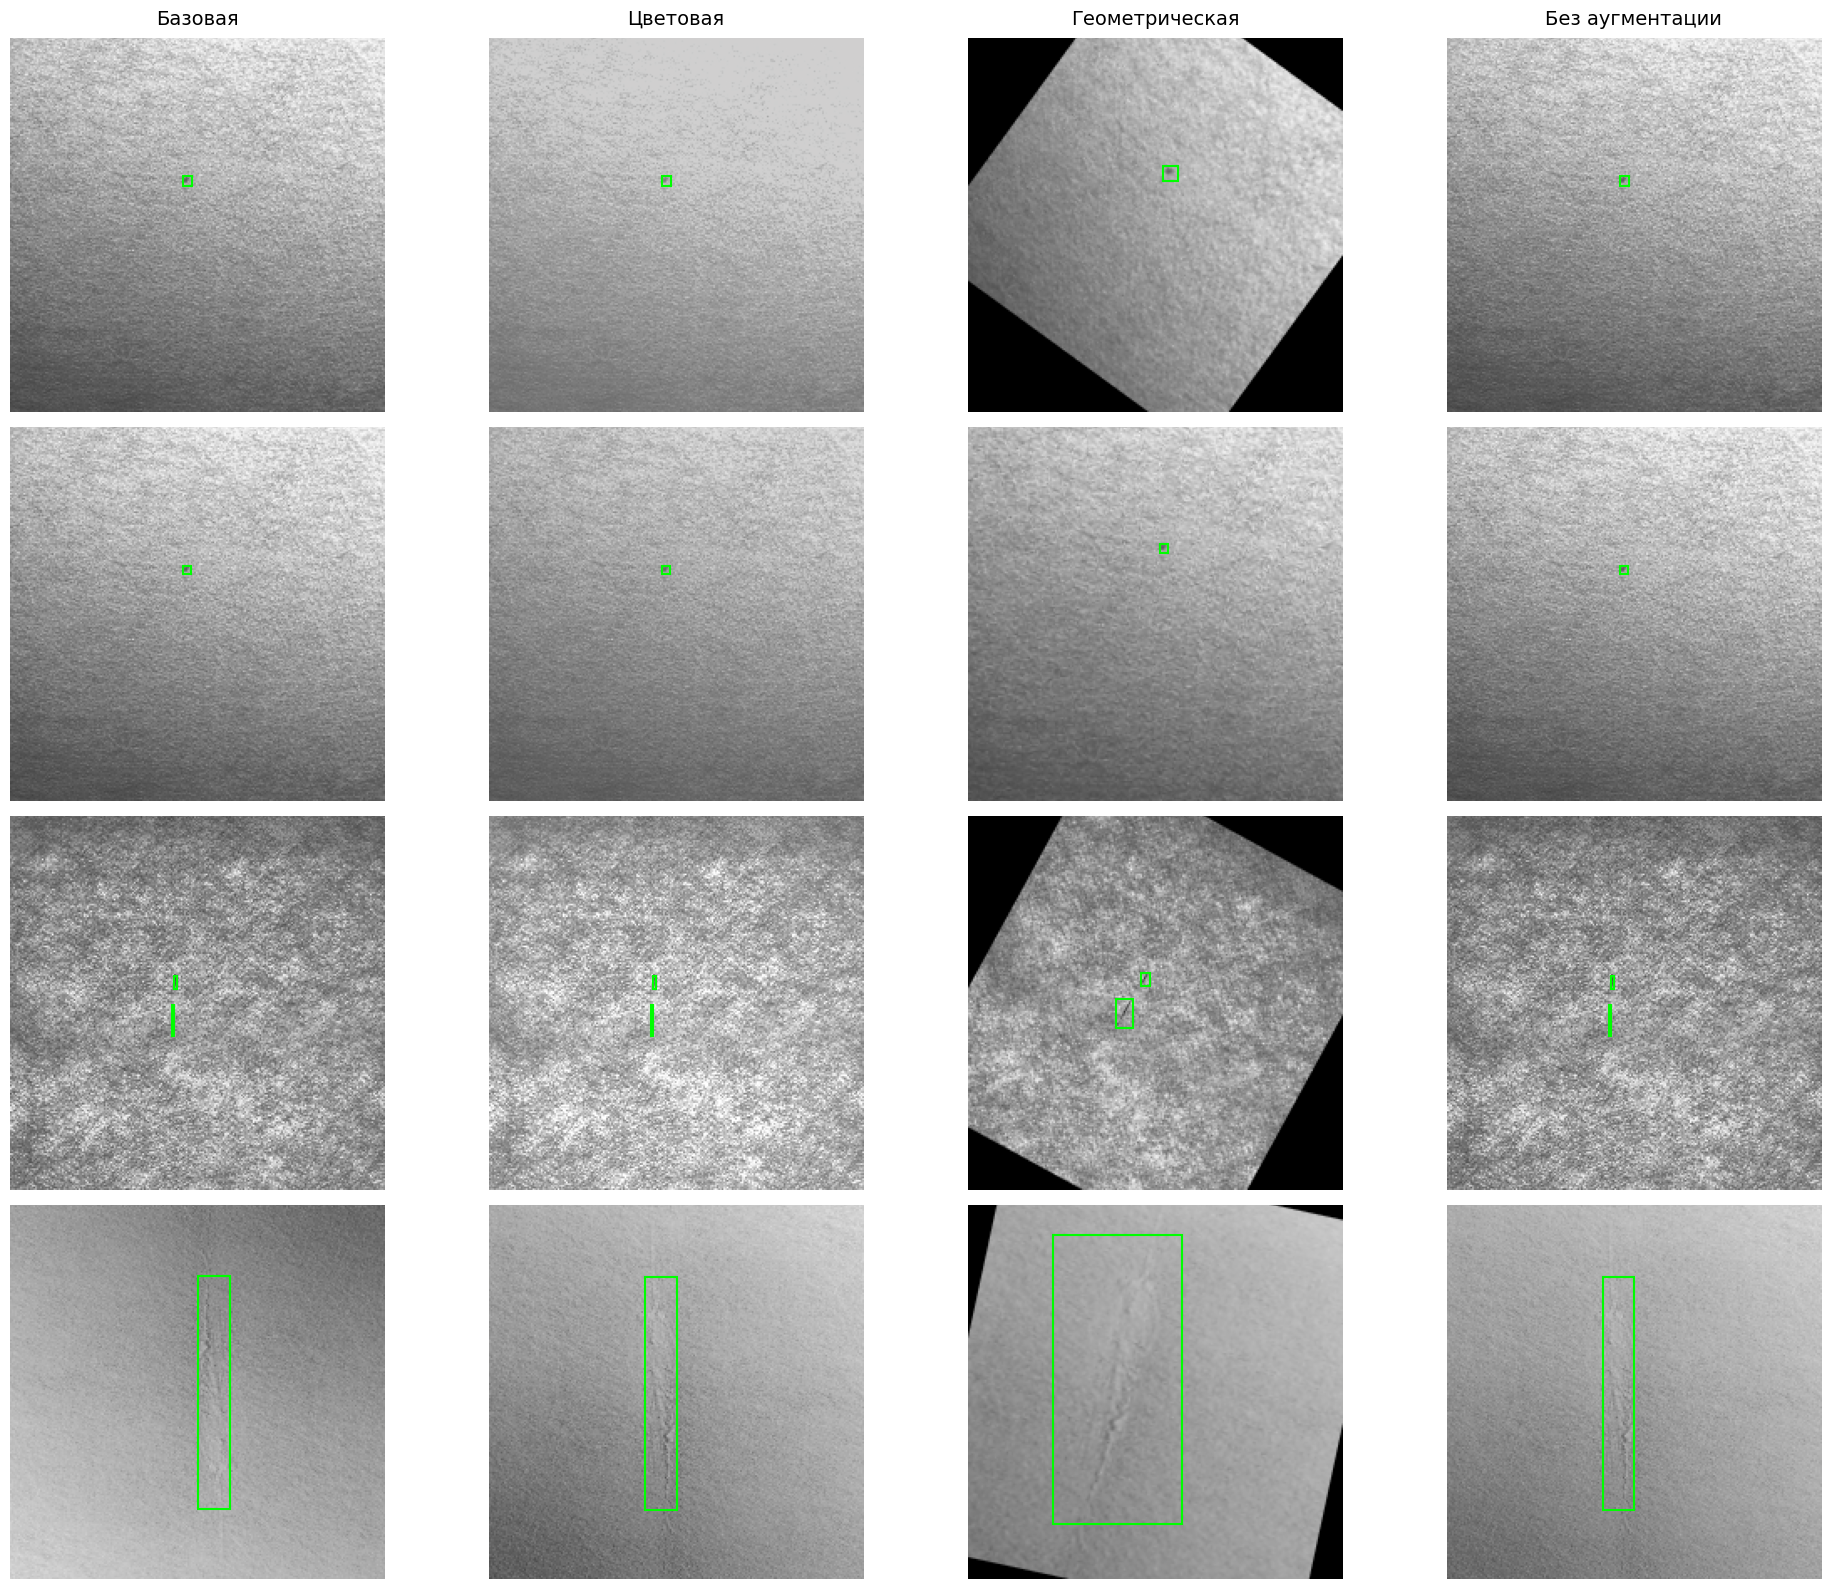

In [41]:
# Конфигурация
BATCH_SIZE = 4
N_TRANSFORMS = 4
TRANSFORMS = {
    'Базовая': base,
    'Цветовая': color,
    'Геометрическая': geo,
    'Без аугментации': no_aug}

# Формарование данных
datasets = {}
loaders = {}

for tf_name, transform in TRANSFORMS.items():
    datasets[tf_name] = FabricDefectDataset(
        root=TRAIN_IMAGES,
        ann_file=TRAIN_ANN,
        transforms=transform)
    
    loaders[tf_name] = DataLoader(
        datasets[tf_name],
        batch_size=BATCH_SIZE,
        shuffle=False,  # Отключаем перемешивание!
        collate_fn=collate_fn,
        num_workers=0)

# Получение батча
batches = {tf_name: next(iter(loader)) for tf_name, loader in loaders.items()}

fig, axes = plt.subplots(BATCH_SIZE, N_TRANSFORMS, figsize=(N_TRANSFORMS*5, BATCH_SIZE*4))

# Денормализация
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

for img_idx in range(BATCH_SIZE):
    for tf_idx, (tf_name, (images, targets)) in enumerate(batches.items()):
        ax = axes[img_idx, tf_idx] if BATCH_SIZE > 1 else axes[tf_idx]
        
        # Изображение и таргет
        img = images[img_idx]
        target = targets[img_idx]
        
        # Тензор в изображение
        img_denorm = img.cpu().clone() * std[:, None, None] + mean[:, None, None]
        img_np = img_denorm.permute(1, 2, 0).clamp(0, 1).numpy()
        
        # Отрисовка
        ax.imshow(img_np)
        ax.axis('off')
        
        # Ббоксы
        boxes = target['boxes'].cpu().numpy() if isinstance(target['boxes'], torch.Tensor) else target['boxes']
        for box in boxes:
            x1, y1, x2, y2 = box
            ax.add_patch(plt.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=1.5,
                edgecolor='lime',
                facecolor='none'))
        
        # Заголовок
        if img_idx == 0:
            ax.set_title(tf_name, fontsize=14, pad=10)

plt.tight_layout()
plt.show()

In [42]:
# Модель и обучение
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, 
        num_classes=2  # background + defect
    )
    return model.to(DEVICE)

def train_step(model, optimizer, images, targets):
    model.train()
    images = [image.to(DEVICE) for image in images]
    targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    return losses.item()

def evaluate(model, dataloader):
    model.eval()
    metric = MeanAveragePrecision()
    
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(DEVICE) for img in images]
            outputs = model(images)
            
            preds = []
            for output in outputs:
                preds.append({
                    'boxes': output['boxes'].cpu(),
                    'scores': output['scores'].cpu(),
                    'labels': output['labels'].cpu()
                })
            
            targets = [{
                'boxes': t['boxes'].cpu(),
                'labels': t['labels'].cpu()
            } for t in targets]
            
            metric.update(preds, targets)
    
    return metric.compute()

In [43]:
results = {}

for strategy_name, augmentation in TRANSFORMS.items():
    print(f"\n=== Training with {strategy_name} augmentation ===")
    
    # Датасеты
    train_dataset = FabricDefectDataset(
        root=TRAIN_IMAGES,
        ann_file=TRAIN_ANN,
        transforms=augmentation  # Передаем конкретную стратегию аугментации
    )
    
    val_dataset = FabricDefectDataset(
        root=VAL_IMAGES,
        ann_file=VAL_ANN,
        transforms=no_aug  # Для валидации используем базовую обработку
    )
    
    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=2,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )
    
    # Инициализация модели
    model = get_model()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    # Обучение
    best_map = 0.0
    for epoch in range(10):
        total_loss = 0.0
        for images, targets in train_loader:
            loss = train_step(model, optimizer, images, targets)
            total_loss += loss
        
        # Валидация
        metrics = evaluate(model, val_loader)
        current_map = metrics['map'].item()
        
        # Отображение процесса
        print(f"Эпоха {epoch+1}/10 | Loss: {total_loss:.2f} | Точность (mAP): {current_map:.3f}")
        
        if current_map > best_map:
            best_map = current_map
            torch.save(model.state_dict(), f"best_{strategy_name}.pth")
    
    results[strategy_name] = best_map

# Результаты
print("\n=== Результат ===")
print(pd.DataFrame.from_dict(results, orient='index', columns=['mAP']))


=== Training with Базовая augmentation ===


c:\Users\KharitWinPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KharitWinPC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 